In [1]:
import pandas as pd
# read one of the filted data sets for useage
data = pd.read_csv('../data/filtered_data/training_data_ros.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12490 entries, 0 to 12489
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__avtisst                   12490 non-null  float64
 1   num__dnrday                    12490 non-null  float64
 2   cat_simple__dnr                12490 non-null  float64
 3   num__adlsc                     12490 non-null  float64
 4   num__prg6m                     12490 non-null  float64
 5   num__adls                      12490 non-null  float64
 6   cat_one_hot__dzgroup_COPD      12490 non-null  float64
 7   num__sps                       12490 non-null  float64
 8   num__aps                       12490 non-null  float64
 9   num__hday                      12490 non-null  float64
 10  cat_one_hot__dzclass_ARF/MOSF  12490 non-null  float64
 11  target                         12490 non-null  float64
dtypes: float64(12)
memory usage: 1.1 MB


In [2]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, classification_report
from scipy.special import expit  # More stable sigmoid function


## Initial version: binomial classification

In [7]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Custom feature transformation
def trans_matrix_for_splines(X):
    # X is (n_samples, 9)
    # Example: add squared terms for nonlinear regression
    X_squared = X ** 2
    intercept = np.ones((X.shape[0], 1))
    return np.hstack([intercept, X, X_squared])

# Logistic loss function (negative log-likelihood)
def average_likelihood_fn(beta, X, y):
    
    # z for linear prediction of logit transformed probability being 1
    z = X @ beta
    
    # p for predicted probability of y being 1
    p = sigmoid(z) # a function of X and beta
    
    # given data and beta, the likelihood of this beta value is 
    epsilon = 1e-9 # to avoid log(0)
    neg_likelihood_beta = -np.mean(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))
    return neg_likelihood_beta # the beta that minimizes this is the best fit on the given data

# Fit model
def fit_logistic(X, y):
    
    # transform/map the design matrix to a higher dimentional space for splines
    X_transformed = trans_matrix_for_splines(X)
    
    # set an initial value to beta vector (0 for now)
    beta_init = np.zeros(X_transformed.shape[1])
    
    # using optimization function from scipy to minimize the negative log-likelihood
    result = minimize(average_likelihood_fn, beta_init, args=(X_transformed, y), method='BFGS')
    
    # return MLE beta (average likelihood function minimized)
    mle_beta = result.x
    return mle_beta

### Waiting to be checked below

In [ ]:
# waiting for the one-vs-rest logistic regression function to be implemented
# fit one-vs-rest logistic regression for multiclass classification
def fit_multiclass_logistic_ovr(X, y, num_classes):
    models = {}
    for cls in range(num_classes):
        y_binary = (y == cls).astype(int)  # One-vs-Rest
        beta = fit_logistic(X, y_binary)   # Use your earlier function
        models[cls] = beta
    return models

# Predict for multiclass
def predict_multiclass(X, models):
    X_transformed = trans_matrix_for_splines(X)
    probs = {}
    for cls, beta in models.items():
        probs[cls] = sigmoid(X_transformed @ beta)
    
    # Combine predictions into a matrix (n_samples x num_classes)
    prob_matrix = np.vstack([probs[cls] for cls in sorted(probs.keys())]).T
    return np.argmax(prob_matrix, axis=1)

## Version 2: transform X to a new design matrix for splines

In [ ]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
# Custom design matrix mapping function
def truncated_power(x, knot, degree):
    return np.where(x > knot, (x - knot) ** degree, 0.0)

def transform_column_with_splines(x_col, degree=3, knots=None, include_intercept=False):
    """
    Transform a single column using spline basis expansion.
    """
    base = [x_col**d for d in range(1, degree + 1)]
    if include_intercept:
        base = [np.ones_like(x_col)] + base
    if knots:
        for knot in knots:
            base.append(truncated_power(x_col, knot, degree))
    return np.column_stack(base)

def transform_matrix_with_splines(X, knots_dict = None, degree=3, include_intercept=False):
    """
    Apply spline transformation to all columns in X with different knots per column.

    Args:
        X: (n, p) input matrix
        knots_dict: dict mapping column index to list of knots for that column
        degree: spline degree (default = 3 for cubic)
        include_intercept: whether to include an intercept term per column (default = False)

    Returns:
        Transformed design matrix (n, ?)
    """
    X = np.asarray(X)
    n, p = X.shape
    transformed_columns = []
    
    # Transform X for splines with transform_matrix_with_splines : includes intercept,
    quantile_knots = [0.25, 0.5, 0.75]    # assuming columns have been standardized

    knots_dict = {
       i: quantile_knots for i in range(X.shape[1])
    }

    for j in range(p):
        x_col = X[:, j]
        knots = knots_dict.get(j, [])  # empty if not specified
        X_j_spline = transform_column_with_splines(x_col, degree, knots, include_intercept)
        transformed_columns.append(X_j_spline)

    return np.hstack(transformed_columns)

In [8]:
# test the above functions on a simulation data 
# Simulate data
def simulate_logistic_data(n_samples=500, n_features=15, seed=42):
    np.random.seed(seed)
    # Simulate predictors X
    X = np.random.normal(0, 1, size=(n_samples, n_features))
    
    # Custom feature transformation
    def trans_matrix_for_splines(X):
        # X is (n_samples, 9)
        # Example: add squared terms for nonlinear regression
        X_squared = X ** 2
        intercept = np.ones((X.shape[0], 1))
        return np.hstack([intercept, X, X_squared])
    
    X_transformed = transform_matrix_with_splines(X, degree = 2, include_intercept=True)
    
    transformed_n_features = X_transformed.shape[1]
    print("Transformed shape:", X_transformed.shape)
    
    # True beta (including intercept)
    true_beta = np.array([(-1)**i * 0.8 / (i+1) for i in range(transformed_n_features)])  # length = # of transformed_n_features
    print("True beta shape:", true_beta.shape)
    
    
    # Compute probabilities using logistic model
    logits = X_transformed @ true_beta
    probs = expit(logits)
    
    # Simulate binary outcome
    y = np.random.binomial(1, probs)
    
    return X, y, true_beta

In [9]:
# change the knots to check 
import LogsiticRegre as lr
X_sim, y_sim, beta_true = simulate_logistic_data()
transformed_x_sim = lr.transform_matrix_with_splines(X_sim, degree=3, include_intercept=True)
estimated_beta = lr.fit_logistic(X_sim, y_sim)

print("True beta (first 10):", np.round(beta_true[:10], 4))
print("Estimated beta (first 10):", np.round(estimated_beta[:10], 4))

Transformed shape: (500, 90)
True beta shape: (90,)
True beta (first 10): [ 0.8    -0.4     0.2667 -0.2     0.16   -0.1333  0.1143 -0.1     0.0889
 -0.08  ]
Estimated beta (first 10): [-0.2339 -0.3019 -0.048  -0.1609 -0.0775 -0.0187 -0.1425 -0.0806 -0.128
  0.0913]


## Version 3: Estimate prior for beta vector

In [54]:
# simulation data and the true beta
X_sim, y_sim, beta_true = simulate_logistic_data()

# bootstraped samples from X_sim and y_sim
def bootstrap_samples(X, y, B = 1000):
    """
    Generate bootstrap samples from the given data.

    Args:
        X (numpy.ndarray): The input feature matrix of shape (n_samples, n_features).
        y (numpy.ndarray): The target vector of shape (n_samples,).
        B (int): The number of bootstrap samples to generate (default is 1000).

    Returns:
        list: A list of tuples, where each tuple contains a bootstrap sample of X and the corresponding y.
    """
    n, p = X.shape
    # Create an array to hold the bootstrap samples
    bootstrap_samples = []
    for _ in range(B):
        idx = np.random.choice(n, size=y.shape, replace=True)
        Xb, yb = X[idx], y[idx]
        bootstrap_samples.append((Xb, yb))
        
    return bootstrap_samples

Transformed shape: (500, 90)
True beta shape: (90,)


In [26]:
# create bootstrap samples
bootstrap_B_samples = bootstrap_samples(X_sim, y_sim, B=1000)

In [59]:
# generate bootstrap estimates of beta
def bootstrap_estimates(X, y, B=1000):
    """
    Generate bootstrap estimates of beta.

    Args:
        X (numpy.ndarray): The input feature matrix of shape (n_samples, n_features).
        y (numpy.ndarray): The target vector of shape (n_samples,).
        B (int): The number of bootstrap samples to generate (default is 1000).

    Returns:
        numpy.ndarray: An array of shape (B, n_features) containing the bootstrap estimates of beta.
    """
    bootstrap_B_samples = bootstrap_samples(X, y, B)
    bootstrap_estimates = np.zeros((B, X.shape[1]))
    
    for i in range(B):
        Xb, yb = bootstrap_B_samples[i]
        transformed_Xb = transform_matrix_with_splines(Xb, degree=2, include_intercept=True)
        beta_b = lr.fit_logistic(Xb, yb)
        bootstrap_estimates[i] = beta_b
        
    return bootstrap_estimates

In [44]:
import matplotlib.pyplot as plt

In [246]:
def visualize_bootstrap_estimates(bootstrap_estimates_results, across_title = '', save_path = '../results/ModelFitting2/bootstrap_estimates_histograms.png'):
    """
    Visualize histograms for all columns in the bootstrap_estimates_results matrix.

    Args:
        bootstrap_estimates_results (numpy.ndarray): Matrix containing bootstrap estimates of beta.
    """

    num_columns = bootstrap_estimates_results.shape[1]
    ncols = 5
    nrows = (num_columns + ncols - 1) // ncols  # Calculate the number of rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2 * nrows))

    # Flatten axes for easier iteration
    axes = axes.flatten()

    for i in range(num_columns):
        ax = axes[i]
        # Plot histogram
        ax.hist(bootstrap_estimates_results[:, i], bins=30, edgecolor='k', alpha=0.7)

        # Calculate 95% confidence interval
        lower_bound = np.percentile(bootstrap_estimates_results[:, i], 2.5)
        upper_bound = np.percentile(bootstrap_estimates_results[:, i], 97.5)

        # Add vertical lines for confidence intervals
        ax.axvline(lower_bound, color='red', linestyle='--', label='2.5% Quantile')
        ax.axvline(upper_bound, color='blue', linestyle='--', label='97.5% Quantile')

        ax.set_title(f"{across_title}Coefficient {i + 1}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Add legend for the first plot only
        if i == 0:
            ax.legend()

    # Hide any unused subplots
    for j in range(num_columns, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)   
    plt.show()

## Test on the real data

In [51]:
import pandas as pd

real_data = pd.read_csv('../data/filtered_data/training_data_ros.csv')
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12490 entries, 0 to 12489
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__avtisst                   12490 non-null  float64
 1   num__dnrday                    12490 non-null  float64
 2   cat_simple__dnr                12490 non-null  float64
 3   num__adlsc                     12490 non-null  float64
 4   num__prg6m                     12490 non-null  float64
 5   num__adls                      12490 non-null  float64
 6   cat_one_hot__dzgroup_COPD      12490 non-null  float64
 7   num__sps                       12490 non-null  float64
 8   num__aps                       12490 non-null  float64
 9   num__hday                      12490 non-null  float64
 10  cat_one_hot__dzclass_ARF/MOSF  12490 non-null  float64
 11  target                         12490 non-null  float64
dtypes: float64(12)
memory usage: 1.1 MB


In [150]:
# for this moment, only consider the target having value 1
real_data_y1 = real_data.copy()
real_data_y1['target'] = real_data_y1['target'].apply(lambda x: 1 if x == 1 else 0)
real_data_y1['target'].value_counts()

# take the first 10 percent observations
real_data_y1_10 = real_data_y1.sample(frac=0.1, random_state=42)
real_data_y1_10.info()
# take out the feature matrix and target vector
X = real_data_y1_10.drop(columns=['target']).values
y = real_data_y1_10['target'].values

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 10105 to 9462
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__avtisst                   1249 non-null   float64
 1   num__dnrday                    1249 non-null   float64
 2   cat_simple__dnr                1249 non-null   float64
 3   num__adlsc                     1249 non-null   float64
 4   num__prg6m                     1249 non-null   float64
 5   num__adls                      1249 non-null   float64
 6   cat_one_hot__dzgroup_COPD      1249 non-null   float64
 7   num__sps                       1249 non-null   float64
 8   num__aps                       1249 non-null   float64
 9   num__hday                      1249 non-null   float64
 10  cat_one_hot__dzclass_ARF/MOSF  1249 non-null   float64
 11  target                         1249 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 126.9 KB


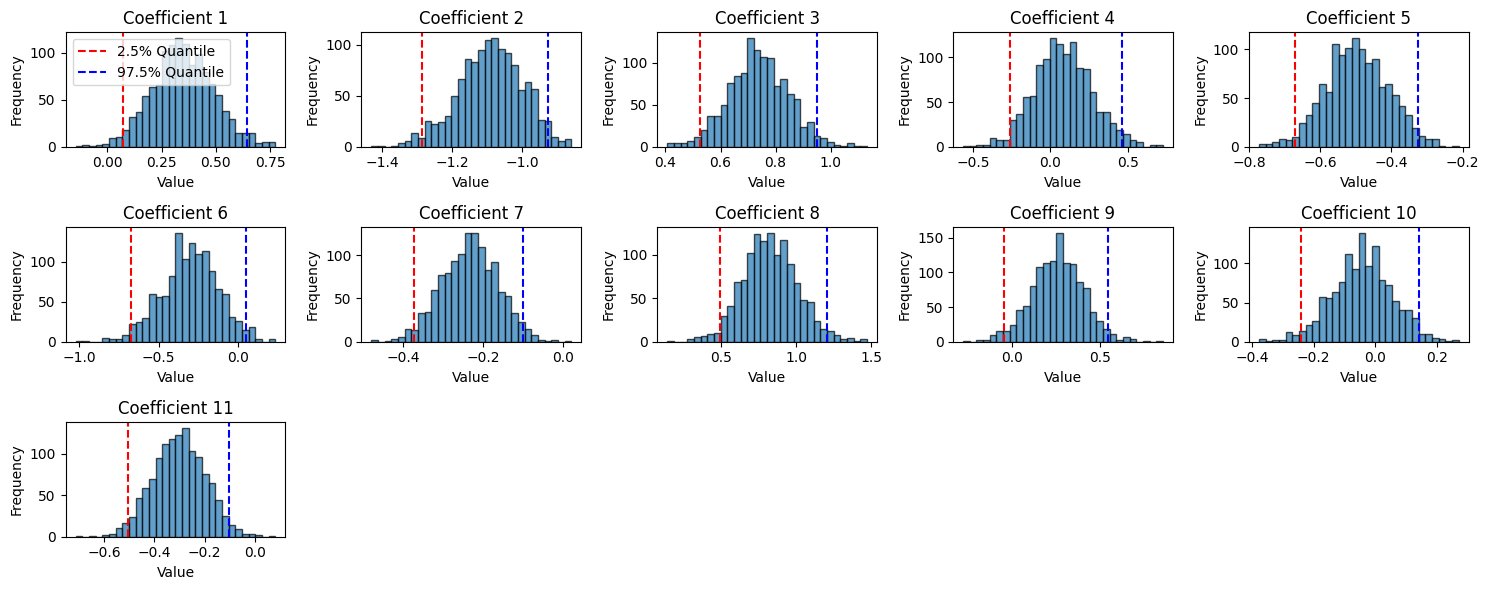

In [231]:
# bootstrap estimates
import importlib
importlib.reload(lr)
bootstrap_estimator = lr.Samples()
bootstrap_estimates_results = bootstrap_estimator.bootstrap_estimates(X, y, B=y.shape[0])
visualize_bootstrap_estimates(bootstrap_estimates_results)

## Posterior Distribution from Bayesian inference

In [ ]:
# using the likelihood function and bootstrap estimates
def posterior_estimates_density(X, y, B = 1000):
    """
    Calculate posterior estimates using likelihood function and bootstrap estimates.
    """
    # mle beta from the original data
    mle_beta = lr.fit_logistic(X, y)
    mle_beta
    
    # bootstrap estimates, prior of beta
    bootstrap_estimator = lr.Samples()
    priors_beta = bootstrap_estimator.bootstrap_estimates(X, y, B=B)

    # Assuming priors_beta and likelihood_boot_betas are defined
    likelihood_boot_betas = []
    
    for i in range(priors_beta.shape[0]):
        beta = priors_beta[i, :]
        likelihood = -lr.average_likelihood_fn(beta, X, y) # caution: the original function is a loss function
        likelihood_boot_betas.append(likelihood)
    
    # Calculate the posterior proportional function values
    posterior_density = np.array(likelihood_boot_betas) * (1 / priors_beta.shape[0])
    
    return priors_beta, posterior_density

In [ ]:
beta_estimates, posterior_density_results = posterior_estimates_density(X, y, B=y.shape[0])

In [460]:
def plot_posterior_density_with_credible_interval(posterior_density_results, lower_quantile=10, upper_quantile=100):
    """
    Plot the histogram of posterior density results with a credible interval.

    Args:
        posterior_density_results (numpy.ndarray): Array of posterior density results.
        lower_quantile (int): Lower quantile for the credible interval (default is 70).
        upper_quantile (int): Upper quantile for the credible interval (default is 100).
    """
    # Calculate the credible interval bounds
    lower_bound = np.percentile(posterior_density_results, lower_quantile)
    upper_bound = np.percentile(posterior_density_results, upper_quantile)

    # Plot the histogram with credible interval
    plt.figure(figsize=(10, 6))
    plt.hist(posterior_density_results, bins=30, edgecolor='k', alpha=0.7)
    plt.axvline(lower_bound, color='red', linestyle='--', label=f'{lower_quantile}% Quantile')
    plt.axvline(upper_bound, color='blue', linestyle='--', label=f'{upper_quantile}% Quantile')
    plt.title("Histogram of Posterior prob of Betas with quantile bounds")
    plt.xlabel("Values propotional to Posterior Density")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig('../results/ModelFitting2/bayesian_posterior_density_histogram.png', dpi = 300)

    plt.show()

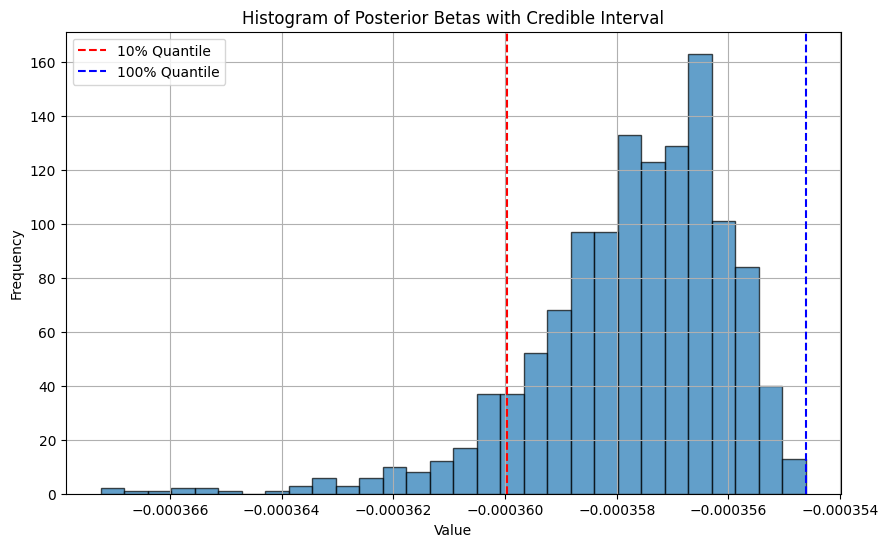

In [228]:
plot_posterior_density_with_credible_interval(posterior_density_results)

In [236]:
# take the most probable beta estimates
def posterior_quantile_betas(posterior_density_results, beta_estimates, top_quantile = 0.9):
        sorted_indices = np.argsort(posterior_density_results)[::-1]
        top_quantile_percent_indices = sorted_indices[:int(top_quantile * len(sorted_indices))]
        # take the corresponding beta values
        top_quantile_betas = beta_estimates[top_quantile_percent_indices]
        # use the mean of the top 30 percent beta values as the final beta
        final_beta = np.mean(top_quantile_betas, axis=0)
        return final_beta

final_beta_results = posterior_quantile_betas(posterior_density_results, beta_estimates, top_quantile=0.9)

In [237]:
final_beta_results

array([ 0.34888402, -1.08524755,  0.74152079,  0.08073437, -0.49842788,
       -0.30028457, -0.23593224,  0.81934824,  0.25979393, -0.04804691,
       -0.3028792 ])

## Test it from module

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 10105 to 9462
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__avtisst                   1249 non-null   float64
 1   num__dnrday                    1249 non-null   float64
 2   cat_simple__dnr                1249 non-null   float64
 3   num__adlsc                     1249 non-null   float64
 4   num__prg6m                     1249 non-null   float64
 5   num__adls                      1249 non-null   float64
 6   cat_one_hot__dzgroup_COPD      1249 non-null   float64
 7   num__sps                       1249 non-null   float64
 8   num__aps                       1249 non-null   float64
 9   num__hday                      1249 non-null   float64
 10  cat_one_hot__dzclass_ARF/MOSF  1249 non-null   float64
 11  target                         1249 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 126.9 KB


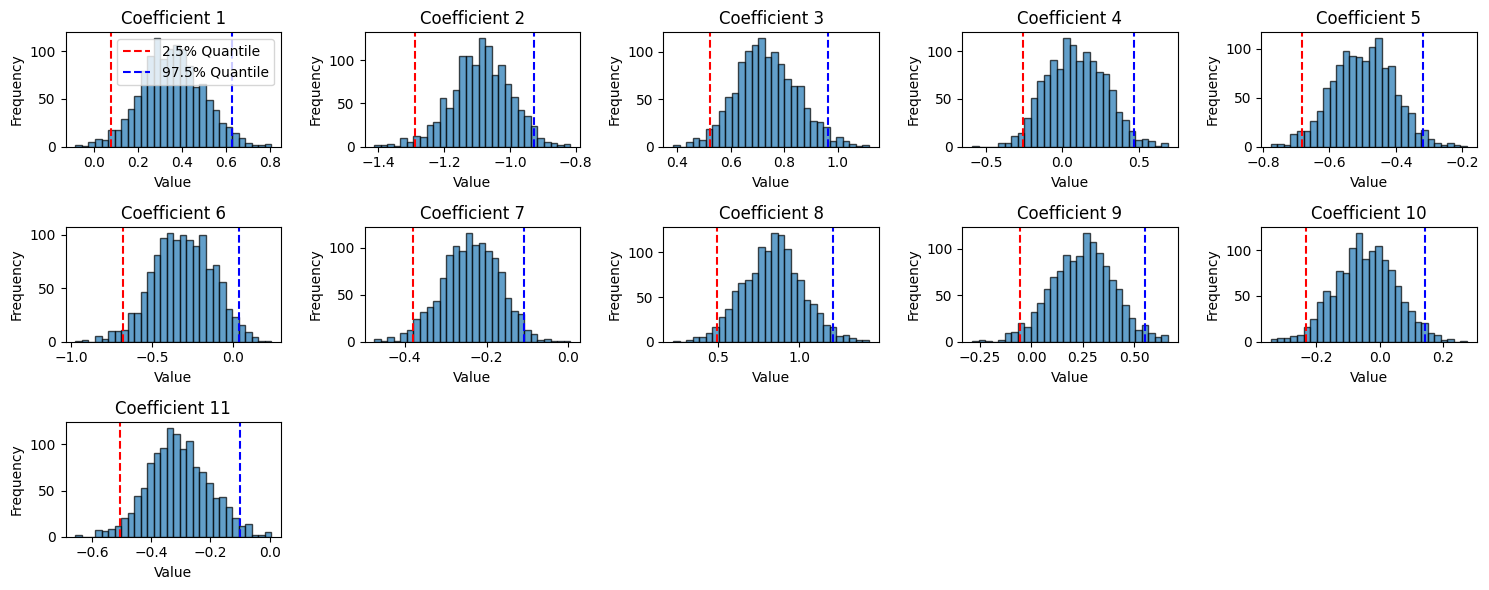

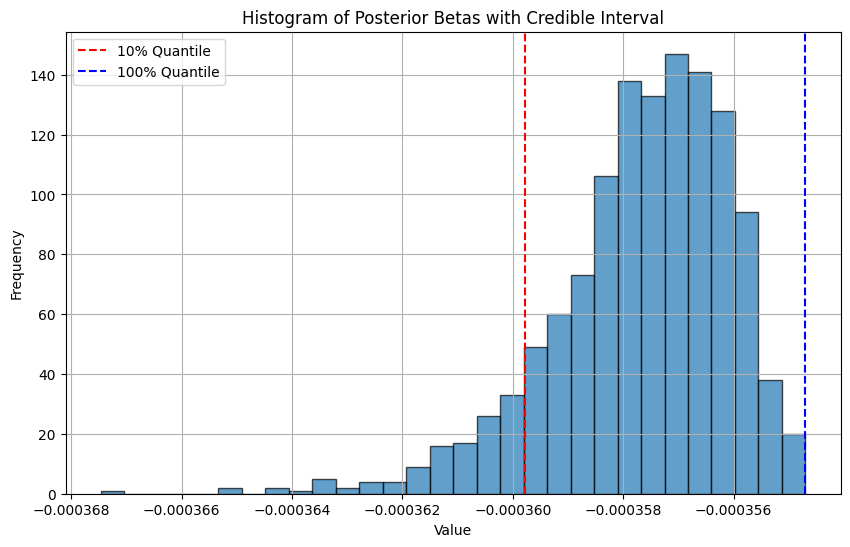

array([ 0.34096089, -1.08017791,  0.73597504,  0.08701339, -0.50103179,
       -0.30766285, -0.23181654,  0.83117285,  0.24545313, -0.04616673,
       -0.30345953])

In [ ]:
importlib.reload(lr)

# Prepare data 
# for this moment, only consider the target having value 1
real_data_y1 = real_data.copy()
real_data_y1['target'] = real_data_y1['target'].apply(lambda x: 1 if x == 1 else 0)
real_data_y1['target'].value_counts()

# take the first 10 percent observations
real_data_y1_10 = real_data_y1.sample(frac=0.1, random_state=42)
real_data_y1_10.info()
# take out the feature matrix and target vector
X = real_data_y1_10.drop(columns=['target']).values
y = real_data_y1_10['target'].values

# prior of beta
bootstrap_estimator = lr.Samples()
bootstrap_estimates_results = bootstrap_estimator.bootstrap_estimates(X, y, B=y.shape[0])
visualize_bootstrap_estimates(bootstrap_estimates_results)

# posterior of beta
post_mc = lr.Posterior()
beta_estimates, posterior_density_results = post_mc.posterior_estimates_density(X, y, B=y.shape[0])

plot_posterior_density_with_credible_interval(posterior_density_results)

posterior_beta_exp = post_mc.posterior_quantile_betas(posterior_density_results, beta_estimates, top_quantile=0.9)
posterior_beta_exp

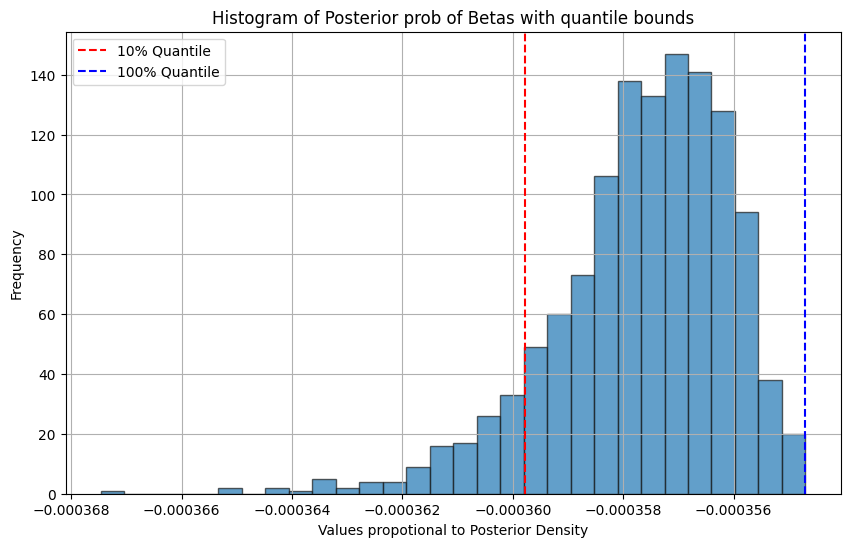

In [461]:
plot_posterior_density_with_credible_interval(posterior_density_results)

In [252]:
def bayesian_logistic_regression(X, y, B=1000):
    """
    Perform Bayesian logistic regression using bootstrap estimates and posterior density.
    
    Args:
        X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
        y (numpy.ndarray): Target vector of shape (n_samples,).
        B (int): Number of bootstrap samples (default is 1000).
    
    Returns:
        tuple: Tuple containing:
            - beta_estimates (numpy.ndarray): Estimated coefficients.
            - posterior_density_results (numpy.ndarray): Posterior density results.
    """
    
    # prior of beta
    bootstrap_estimator = lr.Samples()
    bootstrap_estimates_results = bootstrap_estimator.bootstrap_estimates(X, y, B=y.shape[0])

    # posterior of beta
    post_mc = lr.Posterior()
    beta_estimates, posterior_density_results = post_mc.posterior_estimates_density(X, y, B=y.shape[0])

    # expectation of posterior beta
    posterior_beta_exp = post_mc.posterior_quantile_betas(posterior_density_results, beta_estimates, top_quantile=0.9)
    posterior_beta_exp
    
    return posterior_beta_exp

In [253]:
beyesian_beta = bayesian_logistic_regression(X, y, B = y.shape[0])
beyesian_beta

array([ 0.35460438, -1.08524866,  0.73675809,  0.08956536, -0.49743269,
       -0.3115571 , -0.23886704,  0.82079688,  0.25425315, -0.04299126,
       -0.3085405 ])

In [272]:
# test the initial mle estimate
mle_beta = lr.fit_logistic(X, y)
mle_beta

array([ 0.34652979, -1.07268872,  0.73243756,  0.08508846, -0.4898919 ,
       -0.30609586, -0.23534835,  0.81836441,  0.25063265, -0.04461724,
       -0.30142796])

In [263]:
# define a function to predict the target
def predict_p_values(X, beta, prob_threshold = 0.5, return_probs = True):
    """
    Predict the target probabilities using the logistic regression coefficients.
    
    Args:
        X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
        beta (numpy.ndarray): Coefficients of shape (n_features,).
    
    Returns:
        numpy.ndarray: Predicted probabilities of shape (n_samples,).
    """
    
    # transform the feature matrix
    # transformed_X = transform_matrix_with_splines(X, degree=2, include_intercept=True)
    transformed_X = X
    
    # calculate the logits
    logits = transformed_X @ beta
    
    # calculate the probabilities
    probs = expit(logits)
    
    if not return_probs:
        probs = np.where(probs > prob_threshold, 1, 0)
    
    return probs

In [384]:
# Prepare data 
# for this moment, only consider the target having value 1
def prepare_data(data, target_value = 1):
    # for this moment, only consider the target having value 1
    copy_data = data.copy()
    copy_data['target'] = copy_data['target'].apply(lambda x: 1 if x == target_value else 0)
    
    # take out the feature matrix and target vector
    X = copy_data.drop(columns=['target']).values
    y = copy_data['target'].values
    
    return X, y

In [411]:
data = pd.read_csv('../data/filtered_data/training_data_smote.csv').sample(frac=0.1, random_state=42)
X, y5 = prepare_data(data, target_value = 1)

In [412]:
bayesian_beta = bayesian_logistic_regression(X=X, y=y5, B=y5.shape[0])
mle_beta = lr.fit_logistic(X, y5)
bayesian_pred = predict_p_values(X, bayesian_beta, prob_threshold=0.5, return_probs=False)
mle_pred = predict_p_values(X, mle_beta, prob_threshold=0.5, return_probs=False)

In [413]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Assess the performance of the model

# Basic metrics
y_true = y5

# print("Accuracy:", accuracy_score(y_true, y_pred))
# print("Precision:", precision_score(y_true, y_pred, average='binary'))  # use 'macro' or 'weighted' for multi-class
# print("Recall:", recall_score(y_true, y_pred, average='binary'))
# print("F1 Score:", f1_score(y_true, y_pred, average='binary'))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, mle_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, bayesian_pred))

# Classification report
print("Classification Report:\n", classification_report(y_true, mle_pred))
print("Classification Report:\n", classification_report(y_true, bayesian_pred))

Confusion Matrix:
 [[821 184]
 [ 50 194]]
Confusion Matrix:
 [[821 184]
 [ 50 194]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88      1005
           1       0.51      0.80      0.62       244

    accuracy                           0.81      1249
   macro avg       0.73      0.81      0.75      1249
weighted avg       0.86      0.81      0.83      1249

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88      1005
           1       0.51      0.80      0.62       244

    accuracy                           0.81      1249
   macro avg       0.73      0.81      0.75      1249
weighted avg       0.86      0.81      0.83      1249



## Apply one-vs-rest method for multi-classification

In [385]:
# read data
data = pd.read_csv('../data/filtered_data/augmented_scaled_data.csv')
train_data = data.sample(frac=0.1, random_state=42).copy()

In [366]:
# split the data into 5 copies, each of them is set to have one target value as 1 and 0 rest
# split the whole data set to two parts
train_data = data.sample(frac=0.1, random_state=42).copy()
test_data = data.drop(train_data.index).copy()

# X, y5 = prepare_data(train_data, target_value=5)
# y5

In [347]:
# waiting for the one-vs-rest logistic regression function to be implemented
# fit one-vs-rest logistic regression for multiclass classification
importlib.reload(lr)
def fit_multiclass_logistic_ovr(data, num_classes):
    models = {}
    mle_models = {}
    bayesian_models = {}
    for target in range(num_classes):
        target = target + 1
        X, y = prepare_data(data, target_value=target)
        mle_beta = lr.fit_logistic(X, y)   # Use your earlier function
        bayesian_beta = lr.bayesian_logistic_regression(X, y, B = y.shape[0])
        # store estimate of beta
        mle_models[target] = mle_beta
        bayesian_models[target] = bayesian_beta
    models["MLE"] = mle_models
    models["Bayesian"] = bayesian_models
    return models

In [351]:
multi_models = fit_multiclass_logistic_ovr(train_data, num_classes=5)
multi_models

In [ ]:
# use the models to predict the test data
def predict_multiclass(data, models, return_probs=True):
    y_pred = {}
    for target in range(1, 6):
        X, y = prepare_data(data, target_value=target)
        # use the MLE model to predict
        mle_beta = models["MLE"][target]
        bayesian_beta = models["Bayesian"][target]
        y_pred[target] = {
            "MLE": predict_p_values(X, mle_beta, prob_threshold = 0.5, return_probs = return_probs),
            "Bayesian": predict_p_values(X, bayesian_beta, prob_threshold = 0.5, return_probs=return_probs)
        }
    return y_pred

In [416]:
predicted_results = predict_multiclass(train_data, multi_models, return_probs=False)

In [359]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_classification_model(y_true, y_pred, average='binary', verbose=False):
    """
    Evaluates classification predictions and returns a DataFrame of metrics.
    
    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        average (str): Averaging method for multi-class ('binary', 'macro', 'micro', 'weighted').
        verbose (bool): If True, print confusion matrix and classification report.
    
    Returns:
        pd.DataFrame: DataFrame with evaluation metrics.
    """
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "Recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average=average, zero_division=0),
    }

    if verbose:
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
        print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    
    return pd.DataFrame([metrics])

## Test the whole process from training to assessment

In [435]:
from sklearn.model_selection import train_test_split

# read data
data = pd.read_csv('../data/filtered_data/training_data_ros.csv')
# Perform stratified sampling to ensure class distribution is maintained
train_data, _ = train_test_split(data, test_size=0.99, stratify=data['target'], random_state=42)

multi_models = fit_multiclass_logistic_ovr(train_data, num_classes=5)
predicted_results = predict_multiclass(train_data, multi_models, return_probs=False)

# Initialize an empty list to store DataFrames
results = []

# Loop through each target class
for i in range(5):
    model_num = i + 1
    model_predictions = predicted_results[model_num]
    X, y_true = prepare_data(train_data, target_value=model_num)

    # MLE prediction performance
    mle_performance = evaluate_classification_model(y_true, model_predictions["MLE"], average='binary', verbose=False)
    mle_performance["Model"] = "MLE"
    mle_performance["Target"] = model_num

    # Bayesian prediction performance
    bayesian_performance = evaluate_classification_model(y_true, model_predictions["Bayesian"], average='binary', verbose=False)
    bayesian_performance["Model"] = "Bayesian"
    bayesian_performance["Target"] = model_num

    # Append both results to the list
    results.append(mle_performance)
    results.append(bayesian_performance)

# Concatenate all DataFrames in the list
final_results = pd.concat(results, ignore_index=True)
final_results

,Accuracy,Precision,Recall,F1 Score,Model,Target
0,0.862903,0.611111,0.880000,0.721311,MLE,1
1,0.862903,0.611111,0.880000,0.721311,Bayesian,1
2,0.677419,0.372881,0.880000,0.523810,MLE,2
3,0.701613,0.388889,0.840000,0.531646,Bayesian,2
4,0.669355,0.309524,0.520000,0.388060,MLE,3
5,0.685484,0.315789,0.480000,0.380952,Bayesian,3
6,0.604839,0.254902,0.541667,0.346667,MLE,4
7,0.677419,0.309524,0.541667,0.393939,Bayesian,4
8,0.709677,0.400000,0.880000,0.550000,MLE,5
9,0.741935,0.418605,0.720000,0.529412,Bayesian,5


In [ ]:
# copy the resulting table to clipboard
import pyperclip

def export_df_to_latex_clipboard(df, caption="Model evaluation metrics", label="tab:metrics"):
    latex = r"\begin{table}[!h]" + "\n"
    latex += r"\centering" + "\n"
    latex += rf"\caption{{{caption}}}" + "\n"
    latex += rf"\label{{{label}}}" + "\n"

    # Build header
    header = df.columns.tolist()
    col_format = "c" * len(df.reset_index().columns)  # assume all center aligned
    latex += r"\begin{tabular}{" + col_format + "}\n"
    latex += r"\toprule" + "\n"

    # Column names
    column_names = df.reset_index().columns
    latex += " & ".join([f"\\textbf{{{col}}}" for col in column_names]) + r" \\" + "\n"
    latex += r"\midrule" + "\n"

    # Table body
    for _, row in df.reset_index().iterrows():
        row_str = " & ".join([f"{x:.4f}" if isinstance(x, float) else str(x) for x in row])
        latex += row_str + r" \\" + "\n"

    latex += r"\bottomrule" + "\n"
    latex += r"\end{tabular}" + "\n"
    latex += r"\end{table}"

    # Copy to clipboard
    pyperclip.copy(latex)
    print("✅ LaTeX code copied to clipboard!")

✅ LaTeX code copied to clipboard!


In [438]:
export_df_to_latex_clipboard(final_results.round(decimals = 4))

✅ LaTeX code copied to clipboard!


In [462]:
from sklearn.model_selection import train_test_split

# read data
data = pd.read_csv('../data/filtered_data/training_data_ros.csv')
# Perform stratified sampling to ensure class distribution is maintained
# train_data, _ = train_test_split(data, test_size=0.99, stratify=data['target'], random_state=42)
test_data, _ = train_test_split(data, test_size=0.99, stratify=data['target'], random_state=1)

multi_models = fit_multiclass_logistic_ovr(train_data, num_classes=5)
predicted_results = predict_multiclass(train_data, multi_models, return_probs=False)

# Initialize an empty list to store DataFrames
results = []

# Loop through each target class
for i in range(5):
    model_num = i + 1
    model_predictions = predicted_results[model_num]
    X, y_true = prepare_data(test_data, target_value=model_num)

    # MLE prediction performance
    mle_performance = evaluate_classification_model(y_true, model_predictions["MLE"], average='binary', verbose=False)
    mle_performance["Model"] = "MLE"
    mle_performance["Target"] = model_num

    # Bayesian prediction performance
    bayesian_performance = evaluate_classification_model(y_true, model_predictions["Bayesian"], average='binary', verbose=False)
    bayesian_performance["Model"] = "Bayesian"
    bayesian_performance["Target"] = model_num

    # Append both results to the list
    results.append(mle_performance)
    results.append(bayesian_performance)

# Concatenate all DataFrames in the list
final_results = pd.concat(results, ignore_index=True)
final_results

/Users/gufeng/2025_winter/DASC_5420/Final_Project_5420/src/LogsiticRegre.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


,Accuracy,Precision,Recall,F1 Score,Model,Target
0,0.588710,0.138889,0.200000,0.163934,MLE,1
1,0.588710,0.138889,0.200000,0.163934,Bayesian,1
2,0.483871,0.169492,0.400000,0.238095,MLE,2
3,0.508065,0.189655,0.440000,0.265060,Bayesian,2
4,0.540323,0.119048,0.200000,0.149254,MLE,3
5,0.564516,0.108108,0.160000,0.129032,Bayesian,3
6,0.556452,0.196078,0.416667,0.266667,MLE,4
7,0.596774,0.190476,0.333333,0.242424,Bayesian,4
8,0.451613,0.109091,0.240000,0.150000,MLE,5
9,0.532258,0.133333,0.240000,0.171429,Bayesian,5


In [463]:
export_df_to_latex_clipboard(final_results.round(decimals = 4), caption="Model evaluation metrics on test data", label="tab:metrics_test")

✅ LaTeX code copied to clipboard!


## AUC-ROC curve for model

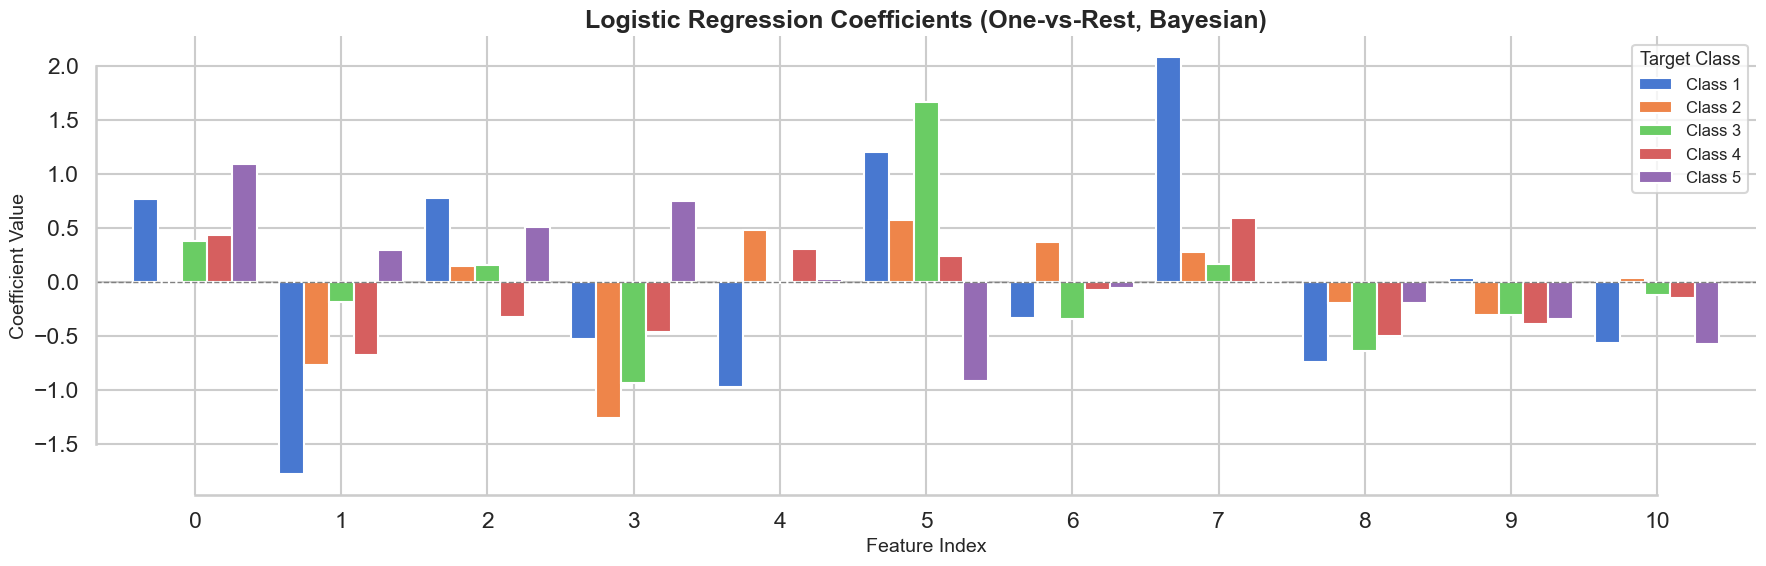

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set prettier theme
sns.set(style="whitegrid", context="talk", palette="muted")

# Your coefficients dictionary
model_dict = multi_models["Bayesian"]
classes = list(model_dict.keys())
coeff_matrix = np.array([model_dict[c] for c in classes])

# Create DataFrame
df_coef = pd.DataFrame(coeff_matrix, index=[f'Class {c}' for c in classes])
df_coef = df_coef.T
df_coef.columns = [f'Class {c}' for c in classes]

# Plot
fig, ax = plt.subplots(figsize=(18, 6))
df_coef.plot(kind='bar', ax=ax, width=0.85)

# Styling
ax.set_title("Logistic Regression Coefficients (One-vs-Rest, Bayesian)", fontsize=18, weight='bold')
ax.set_xlabel("Feature Index", fontsize=14)
ax.set_ylabel("Coefficient Value", fontsize=14)
ax.tick_params(axis='x', rotation=0)
ax.legend(title="Target Class", fontsize=12, title_fontsize=13)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('../results/ModelFitting2/bayesian_coef_plot.png', dpi=300)
plt.show()

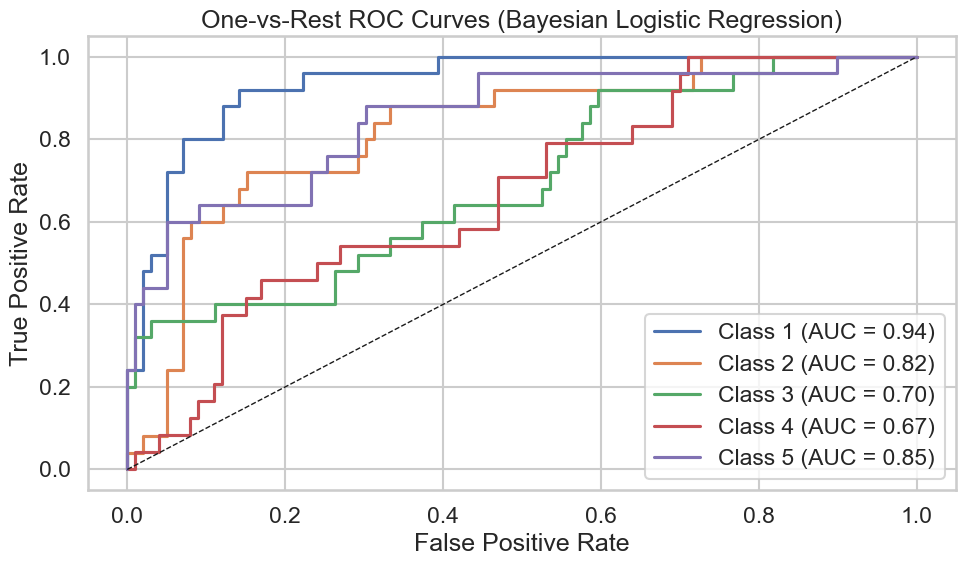

In [450]:
from scipy.special import expit  # Sigmoid
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

X_test = train_data.drop(columns=['target']).values
y_test = train_data['target'].values

def predict_proba_ovr(X, model_dict):
    """
    Predict class probabilities using one-vs-rest logistic regression.
    
    Args:
        X: (n_samples, n_features)
        model_dict: {class_label: coefficient_array}
    
    Returns:
        probs: (n_samples, n_classes) matrix of predicted probabilities
    """
    n_classes = len(model_dict)
    probs = []

    for cls in sorted(model_dict.keys()):
        beta = model_dict[cls]
        logits = X @ beta
        probs.append(expit(logits))  # Sigmoid function
    
    return np.vstack(probs).T  # Shape: (n_samples, n_classes)

# Predict probabilities
y_score = predict_proba_ovr(X_test, multi_models["Bayesian"])  # shape: (n_samples, n_classes)

# Binarize true labels
classes = sorted(multi_models["Bayesian"].keys())
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes)

# Plot settings
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", context="talk")

# Plot ROC for each class
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels & legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves (Bayesian Logistic Regression)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../results/ModelFitting2/roc_curve_bayesian.png', dpi=300)
plt.show()